# Estimate non-stationary internal wave parameters on the Ponte and Klein 2015 data

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from cmocean import cm
from scipy.interpolate import interp1d
from scipy import signal
from tqdm import tqdm
import speccy
import nonstat_itides as nsit
from gptide import stats as gpstats
from gptide import cov

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [3]:
## Download the data
##!curl https://dataverse.scholarsportal.info/api/access/datafile/170108 -o ../DATA/wp50-t1.nc
#!wget https://dataverse.scholarsportal.info/api/access/datafile/170118 -O ../DATA/wp50-t2.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170111 -O ../../SouthernOceanIWaves/DATA/wp50-t3.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170113 -O ../DATA/wp90-t1.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170112 -O ../DATA/wp90-t2.nc
#!wget https://dataverse.scholarsportal.info/api/access/datafile/170114 -O ../../SouthernOceanIWaves/DATA/wp90-t3.nc

# !wget https://dataverse.scholarsportal.info/api/access/datafile/170117 -O ../../SouthernOceanIWaves/DATA/wp60-t1.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170121 -O ../../SouthernOceanIWaves/DATA/wp60-t2.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170120 -O ../../SouthernOceanIWaves/DATA/wp60-t3.nc

# !wget https://dataverse.scholarsportal.info/api/access/datafile/170109 -O ../../SouthernOceanIWaves/DATA/wp75-t1.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170116 -O ../../SouthernOceanIWaves/DATA/wp75-t2.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170110 -O ../../SouthernOceanIWaves/DATA/wp75-t3.nc

# !wget https://dataverse.scholarsportal.info/api/access/datafile/170122 -O ../../SouthernOceanIWaves/DATA/wp80-t1.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170119 -O ../../SouthernOceanIWaves/DATA/wp80-t2.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170115 -O ../../SouthernOceanIWaves/DATA/wp80-t3.nc

In [4]:

# Create nicer dimensions
def load_pk2015(ncfile,datavar='ssh'):
    ds = xr.open_dataset(ncfile)
    dx = 4.0
    if len(ds['{}_lof'.format(datavar)].dims)==4:
        tdim, zdim, ydim, xdim = ds['{}_lof'.format(datavar)].dims
    else:
        tdim, ydim, xdim = ds['{}_lof'.format(datavar)].dims
    x = ds[xdim].values*dx
    y = ds[ydim].values*dx

    t0 = np.datetime64('1950-01-01 00:00:00')
    tdays = (ds.time_centered.values - t0).astype(float)*1e-9/86400.
    print(ncfile, tdays[0], tdays[-1],ds.time_centered.values[0])
    return xr.Dataset(
        {'{}_lof'.format(datavar):
            xr.DataArray(ds['{}_lof'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
         '{}_cos'.format(datavar):
            xr.DataArray(ds['{}_cos'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
         '{}_sin'.format(datavar):
            xr.DataArray(ds['{}_sin'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
        })

def load_scenario(scenario, datadir):
        ds_v = xr.concat([load_pk2015(ff, datavar='v_xy') for ff in sorted(glob('{}/{}-t*.nc'.format(datadir, scenario)))], dim='time')
        ds_u = xr.concat([load_pk2015(ff, datavar='u_xy') for ff in sorted(glob('{}/{}-t*.nc'.format(datadir, scenario)))], dim='time')
        ds_ssh = xr.concat([load_pk2015(ff, datavar='ssh') for ff in sorted(glob('{}/{}-t*.nc'.format(datadir, scenario)))], dim='time')
        ds = xr.merge([ds_v, ds_u, ds_ssh])
        ds['time'] = np.arange(ds.time[0], ds.time[0]+ds.time.shape[0]*2, 2)

        return ds
    
def calc_raw(ds, xpt, ypt, dtout, varname):
    omega = 2*np.pi*2. # 2 cpd

    tfast = np.arange(ds.time.values[0], ds.time.values[-1], dtout)

    F = interp1d(ds.time.values, ds['{}_lof'.format(varname)].isel(x=xpt, y=ypt), kind=2)
    vlow = F(tfast)
    F = interp1d(ds.time.values, ds['{}_cos'.format(varname)].isel(x=xpt, y=ypt), kind=2)
    vcos = F(tfast)
    F = interp1d(ds.time.values, ds['{}_sin'.format(varname)].isel(x=xpt, y=ypt), kind=2)
    vsin = F(tfast)

    vraw = vlow + vcos*np.cos(omega*tfast) + vsin*np.sin(omega*tfast)
    
    return tfast, vraw, vlow



In [5]:
def subset_data(ds):
    # Remove the mean from the cos and sin to leave the incoherent signal
    # ...also subset the domain for faster computation
    yslice = slice(35,680, 2)
    #xslice = slice(128,129,1)
    xslice = slice(None, None, 10)

    ds_nonstat = ds.isel(time=slice(10,150), y=yslice, x=xslice)
    ds_nonstat['ssh_cos'] = ds['ssh_cos'] - ds['ssh_cos'].mean(axis=0)
    ds_nonstat['ssh_sin'] = ds['ssh_sin'] - ds['ssh_sin'].mean(axis=0)

    ds_nonstat['ssh_cos_stat'] = ds['ssh_cos'].mean(axis=0)
    ds_nonstat['ssh_sin_stat'] = ds['ssh_sin'].mean(axis=0)

    return ds_nonstat

In [6]:
def itmodel_matern_log(x, xpr, params, l=0.5):
    
    log_eta, log_d,  logit_nu = params
   
    eta = np.exp(log_eta)
    d = np.exp(log_d)
    nu = nsit.invlogit(logit_nu, scale=3.5)

    return nsit.oscillate_1d_matern(x, xpr, (eta, d, l, nu) )

def itmodel_gamma_log(x, xpr, params, l=0.5):
    
    log_eta, log_d,  logit_gam = params
   
    eta = np.exp(log_eta)
    d = np.exp(log_d)
    gam = nsit.invlogit(logit_gam, scale=2.)

    return nsit.oscillate_1d_gammaexp(x, xpr, (eta, d, l, gam) )

def itmodel_matern(x, xpr, params, l=0.5):
    
    eta, d,  logit_nu = params
    
    #nu = nsit.invlogit(logit_nu, scale=3.5)

    return nsit.oscillate_1d_matern(x, xpr, (eta, d, l, nu) )

def itmodel_gamma(x, xpr, params, l=0.5):
    
    eta, d,  gam = params
    #gam = nsit.invlogit(logit_gam, scale=2.)

    return nsit.oscillate_1d_gammaexp(x, xpr, (eta, d, l, gam) )

def itmodel_gamma_fixed(x, xpr, params, l=0.5, gam=2.):
    
    eta, d = params
    
    return nsit.oscillate_1d_gammaexp(x, xpr, (eta, d, l, gam) )

def itmodel_expquad(x, xpr, params, l=0.5):

    #     log_eta, log_d = params

    #     eta = np.exp(log_eta)
    #     d = np.exp(log_d)
    eta, d = params
    
    return nsit.oscillate_1d(x, xpr, (eta, d, l), itfunc=cov.expquad )

def itmodel_lorentzian(x, xpr, params, l=0.5):
    
    eta, d = params
    
    return nsit.oscillate_1d(x, xpr, (eta, d, l), itfunc=nsit.matern12 )

def itmodel_matern(x, xpr, params, l=0.5):
    
    eta, d,  nu = params
   

    return nsit.oscillate_1d_matern(x, xpr, (eta, d, l, nu) )

def estimate_spectral_params_whittle_ufunc(y, priors=None, X=None, covfunc=None, covparams_ic=None, fmin=None, fmax=None, 
                                          method='nelder-mead',
                                          options={'maxiter':5000},
                                          callback=None,
                                          bounds=None):
    """
    Function that xarray.apply_func can handle
    """
    return nsit.estimate_spectral_params_whittle(y, X, covfunc, covparams_ic, fmin, fmax, 
                                            priors=priors,
                                            method=method, options=options, callback=callback, bounds=bounds)


In [9]:
def process_scenario(scenario, datadir, covfunc, covparams, paramnames, bounds, fmin, fmax, dtout,
                    priors=None):
    
    print(scenario)
    ds = load_scenario(scenario, datadir)
    
    ds_nonstat = subset_data(ds)
    
    nparams = len(covparams)
    
    paramsout = np.zeros((ds_nonstat.dims['y'],ds_nonstat.dims['x'], nparams))
    for jj in tqdm(range(ds_nonstat.dims['y'])):
        for ii in range(0,ds_nonstat.dims['x']):
            t, y, ylow = calc_raw(ds_nonstat, ii, jj, dtout, 'ssh')
            
            inputs = dict(priors=priors, X=t, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax, 
                  method='nelder-mead', bounds=bounds)

            soln = nsit.estimate_spectral_params_whittle_ufunc(y-y.mean(), **inputs)
            paramsout[jj,ii,:] = soln
            
    da_paramsout = xr.DataArray(paramsout, dims=('y','x','params'),
                           coords={'y':ds_nonstat['y'],'x':ds_nonstat['x'], 'params':range(0,nparams)},
                           attrs={'parameter names':paramnames,
                          'covariance function':covfunc.__name__})

    ds_nonstat['data'] = da_paramsout
    
    outfile = '{}/{}_itide_params_{}.nc'.format(datadir, scenario, covfunc.__name__)

    ds_nonstat.to_netcdf(outfile, mode='w')
    print(outfile)
    
    return ds_nonstat


In [10]:
eta1 = 0.007
dt1 =  5
gam1 = 1.5
fmin, fmax = 1.6, 2.4
# covfunc = itmodel_gamma
covfunc = itmodel_lorentzian



# covparams = (eta1, dt1, gam1)
# paramnames=['η','ℓ','γ']

covparams = (eta1, dt1)
paramnames=['η','ℓ']

# bounds=None
# bounds = [(1e-15, 1.), (1e-15, 15.), (1, 2-1e-15)]
bounds = [(1e-15, 1.), (1e-15, 15.)]

datadir = '../../SouthernOceanIWaves/DATA'

dtout = 1/72.
####

scenarios = ['wp50','wp60','wp75','wp80','wp90']
for ss in scenarios[-1:]:
    process_scenario(ss, datadir, covfunc, covparams, paramnames, bounds, fmin, fmax, dtout)

wp90
../../SouthernOceanIWaves/DATA/wp90-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp90-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000


100%|██████████| 323/323 [23:11<00:00,  4.31s/it]


../../SouthernOceanIWaves/DATA/wp90_itide_params_itmodel_lorentzian.nc


## Testing below here...

In [26]:
scenario = 'wp50'
datadir = '../../SouthernOceanIWaves/DATA'
ds = load_scenario(scenario, datadir)
ds

../../SouthernOceanIWaves/DATA/wp50-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t1.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t2.nc 1.0 99.0 1950-01-02T00:00:00.000000000
../../SouthernOceanIWaves/DATA/wp50-t3.nc 1.0 99.0 1950-01-02T00:00:00.000000000


<xarray.Dataset>
Dimensions:   (x: 258, y: 722, time: 150)
Coordinates:
  * x         (x) float64 0.0 4.0 8.0 12.0 ... 1.02e+03 1.024e+03 1.028e+03
  * y         (y) float64 0.0 4.0 8.0 12.0 ... 2.876e+03 2.88e+03 2.884e+03
  * time      (time) float64 1.0 3.0 5.0 7.0 9.0 ... 293.0 295.0 297.0 299.0
Data variables:
    v_xy_lof  (time, y, x) float32 5.238e-05 5.236e-05 5.233e-05 ... nan nan nan
    v_xy_cos  (time, y, x) float32 -3e-06 -2.999e-06 -2.996e-06 ... nan nan nan
    v_xy_sin  (time, y, x) float32 -1.497e-06 -1.492e-06 -1.486e-06 ... nan nan
    u_xy_lof  (time, y, x) float32 0.0001713 0.0001597 ... 0.009025 nan
    u_xy_cos  (time, y, x) float32 5.517e-07 6.935e-07 ... 8.547e-05 nan
    u_xy_sin  (time, y, x) float32 6.464e-06 6.505e-06 ... -0.002929 nan
    ssh_lof   (time, y, x) float32 0.3899 0.3899 0.3899 ... -0.3907 -0.3908
    ssh_cos   (time, y, x) float32 1.194e-06 1.192e-06 ... -0.001523 -0.001658
    ssh_sin   (time, y, x) float32 -1.248e-06 -1.317e-06 ... -0.001071 -0.001042

/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


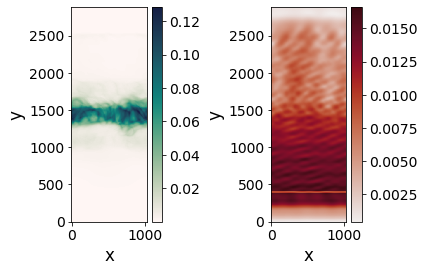

In [28]:
# Plot some metrics
EKE = 0.5*(ds['u_xy_lof'].var(axis=0) + ds['v_xy_lof'].var(axis=0))
APE = ds['ssh_lof'].var(axis=0) 

ITamp = np.abs(ds['ssh_cos'].mean(axis=0)+1j*ds['ssh_sin'].mean(axis=0))

plt.figure()
plt.subplot(121)
# APE.plot()
EKE.plot(cmap='cmo.tempo')

plt.subplot(122)
# APE.plot()
ITamp.plot(cmap='cmo.amp')

plt.tight_layout()

CPU times: user 50.7 ms, sys: 0 ns, total: 50.7 ms
Wall time: 48.8 ms


(1.0, 3.0)

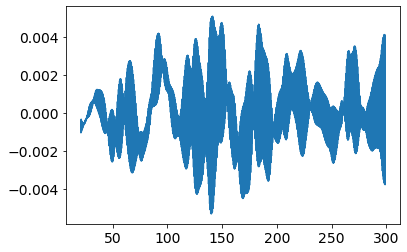

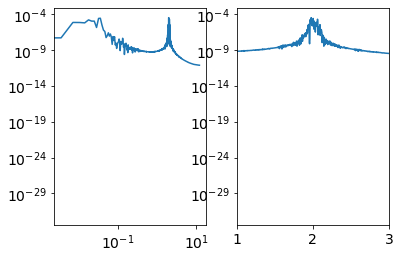

In [29]:
%%time

# Test site
dtout = 1/24
t, y, ylow = calc_raw(ds_nonstat, 0, 10, dtout, 'ssh') 
# t, y, ylow = calc_raw(ds, 128, 580, dtout, 'ssh') 

plt.figure()
plt.plot(t, y-y.mean())


f, I =  speccy.periodogram(y-y.mean(), delta=dtout)

plt.figure()
ax1=plt.subplot(121)
plt.loglog(f, I)

ax2=plt.subplot(122)
plt.semilogy(f, I)
ax2.set_xlim(1,3)

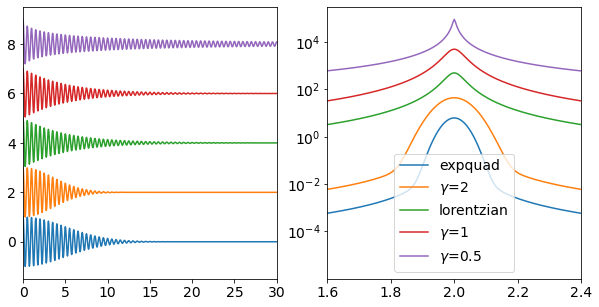

In [32]:
# Plot some acf/psd
plt.figure(figsize=(10,5))
ax1=plt.subplot(121)
ax2=plt.subplot(122)
ax1.set_xlim(0,30)
ax2.set_xlim(1.6,2.4)


scale=1
offset=np.log10(scale)*2
acf1 = itmodel_expquad(t, t[0], (1, 5.))
f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p1a, = ax1.plot(t-t[0],acf1+offset)
p1b, = ax2.semilogy(f_S1, S1*scale)

scale*=10
offset=np.log10(scale)*2
# acf1 = itmodel_gamma(t, t[0], (1, 5., nsit.logit(2-1e-15, scale=2)))
acf1 = itmodel_gamma(t, t[0], (1, 5., 2))

f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p2a, = ax1.plot(t-t[0],acf1+offset)
p2b, = ax2.semilogy(f_S1, S1*scale)

scale*=10
offset=np.log10(scale)*2
acf1 = itmodel_lorentzian(t, t[0], (1, 5.))
f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p3a, = ax1.plot(t-t[0],acf1+offset)
p3b, = ax2.semilogy(f_S1, S1*scale)

scale*=10
offset=np.log10(scale)*2
# acf1 = itmodel_gamma(t, t[0], (1, 5., nsit.logit(1, scale=2)))
acf1 = itmodel_gamma(t, t[0], (1, 5., 1))

f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p4a, = ax1.plot(t-t[0],acf1+offset)
p4b, = ax2.semilogy(f_S1, S1*scale)

scale*=10
offset=np.log10(scale)*2
# acf1 = itmodel_gamma(t, t[0], (1, 5., nsit.logit(0.5, scale=2)))
acf1 = itmodel_gamma(t, t[0], (1, 5., 0.5))

f_S1, S1 = speccy.bochner(acf1, delta=dtout)
p5a, = ax1.plot(t-t[0],acf1+offset)
p5b, = ax2.semilogy(f_S1, S1*scale)

# scale*=10
# offset=np.log10(scale)*2
# acf1 = itmodel_matern(t, t[0], (1, 5., 0.5))
# f_S1, S1 = speccy.bochner(acf1, delta=dtout)
# p6a, = ax1.plot(t-t[0],acf1+offset)
# p6b, = ax2.semilogy(f_S1, S1*scale)

# scale*=10
# offset=np.log10(scale)*2
# acf1 = itmodel_matern(t, t[0], (1, 5., 1.5))
# f_S1, S1 = speccy.bochner(acf1, delta=dtout)
# p6a, = ax1.plot(t-t[0],acf1+offset)
# p6b, = ax2.semilogy(f_S1, S1*scale)


# scale*=10
# offset=np.log10(scale)*2
# acf1 = itmodel_matern(t, t[0], (1, 5., 3.5))
# f_S1, S1 = speccy.bochner(acf1, delta=dtout)
# p6a, = ax1.plot(t-t[0],acf1+offset)
# p6b, = ax2.semilogy(f_S1, S1*scale)

ax2.legend( (p1a,p2b,p3b,p4b,p5b),('expquad',r'$\gamma$=2','lorentzian',r'$\gamma$=1',r'$\gamma$=0.5'),)

In [33]:
#########
# Inputs

#eta1 = np.log(0.007)
#dt1 =  np.log(5)
# nu1 = 2.
eta1 = 0.007
dt1 =  5
nu1 = 1.5
fmin, fmax = 1.6, 2.4
# covfunc = itmodel_matern_log
# covfunc = itmodel_gamma_fixed
# covfunc = itmodel_expquad
# covfunc = itmodel_matern

# covfunc = itmodel_lorentzian
covfunc = itmodel_gamma



# priors = [
#         gpstats.truncnorm(0.01, 0.005, 1e-15, 1.),              # η
#         gpstats.truncnorm(2.5, 2.5, 1e-15, 5.),         # ℓ 
#         gpstats.truncnorm(3, 1, 1e-15, 5),
#                    ]

priors=None

covparams = (eta1, dt1, nu1)
paramnames=['η','ℓ','γ']

# covparams = (eta1, dt1)
# paramnames=['η','ℓ']

# bounds=None
bounds = [(1e-15, 1.), (1e-15, 10.), (1, 2-1e-15)]
# bounds = [(1e-15, 1.), (1e-15, 10.)]

outpath ='../../SouthernOceanIWaves/DATA'
#############
nparams = len(covparams)
outfile = '{}/{}_itide_params_{}.nc'.format(outpath, scenario, covfunc.__name__)

print(outfile)

../../SouthernOceanIWaves/DATA/wp50_itide_params_itmodel_gamma.nc


[1.43023332e-03 5.94555383e+00 1.92753977e+00]
CPU times: user 182 ms, sys: 3 µs, total: 182 ms
Wall time: 181 ms


Text(0.5, 0, 'f [cpd]')

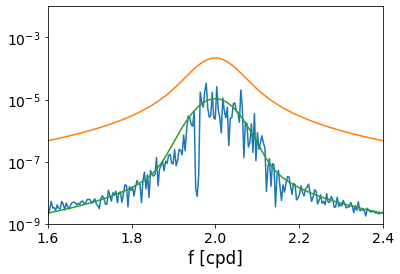

In [34]:
%%time

# Test point
acf1 = covfunc(t, t[0], covparams)
f_S1, S1 = speccy.bochner(acf1, delta=dtout)

inputs = dict(priors=priors, X=t, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax, 
              method='nelder-mead', bounds=bounds)
soln = estimate_spectral_params_whittle_ufunc(y-y.mean(), **inputs)

# print(np.exp(soln[0:2]), nsit.invlogit(soln[2], scale=2))
# print(np.exp(soln[0:2]), nsit.invlogit(soln[2], scale=3.5))
print(soln)
acf = covfunc(t, t[0], soln)

f_S, S = speccy.bochner(acf, delta=dtout)
plt.figure()
plt.semilogy(f, I)
plt.semilogy(f_S1,S1)
plt.semilogy(f_S,S)

plt.xlim(fmin, fmax)
plt.ylim(1e-9,1e-2)

plt.xlabel('f [cpd]')

In [36]:
inputs = dict(priors=priors, X=t, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax, 
              method='nelder-mead', bounds=bounds)

paramsout = np.zeros((ds_nonstat.dims['y'],ds_nonstat.dims['x'], nparams))
for jj in tqdm(range(ds_nonstat.dims['y'])):
    for ii in range(0,ds_nonstat.dims['x']):
        t, y, ylow = calc_raw(ds_nonstat, ii, jj, dtout, 'ssh')

        soln = nsit.estimate_spectral_params_whittle_ufunc(y-y.mean(), **inputs)
        paramsout[jj,ii,:] = soln
        # Use the last step as an IC...
        #inputs = dict(priors=priors, X=t, covfunc=itmodel_matern, covparams_ic=soln, fmin=fmin, fmax=fmax, method='nelder-mead')

 40%|████      | 130/323 [09:39<15:34,  4.84s/it]/data-obs/jupyter-ubuntu/ProjectsActive/SWOT_NAust/NOTEBOOKS/nonstat_itides.py:257: RuntimeWarning: divide by zero encountered in log
  return - 2 * np.sum(np.log(S_boch[idx_boch]) + I[idx]/S_boch[idx_boch])
/data-obs/jupyter-ubuntu/ProjectsActive/SWOT_NAust/NOTEBOOKS/nonstat_itides.py:257: RuntimeWarning: divide by zero encountered in true_divide
  return - 2 * np.sum(np.log(S_boch[idx_boch]) + I[idx]/S_boch[idx_boch])
/data-obs/jupyter-ubuntu/ProjectsActive/SWOT_NAust/NOTEBOOKS/nonstat_itides.py:257: RuntimeWarning: invalid value encountered in add
  return - 2 * np.sum(np.log(S_boch[idx_boch]) + I[idx]/S_boch[idx_boch])
100%|██████████| 323/323 [24:25<00:00,  4.54s/it]


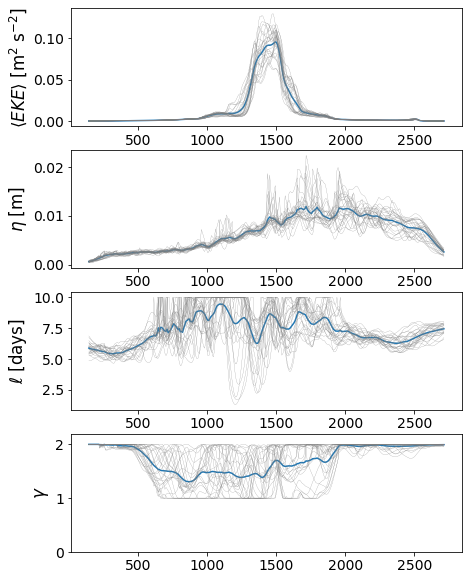

In [37]:
EKE = 0.5*(ds_nonstat['u_xy_lof'].var(axis=0) + ds_nonstat['v_xy_lof'].var(axis=0))

plt.figure(figsize=(7,10))

ax1=plt.subplot(411)
# plt.plot(ds['y'], np.exp(paramsout[:,0]),'.')
plt.plot(ds_nonstat['y'], EKE.mean(axis=1),'-')
for ii in range(ds_nonstat.dims['x']):
    plt.plot(ds_nonstat['y'], EKE[:,ii],'0.5',lw=.2)
plt.ylabel(r'$\langle EKE \rangle$ [m$^2$ s$^{-2}$]')
# plt.ylim(0,0.025)


ax1=plt.subplot(412)
# plt.plot(ds_nonstat['y'], np.exp(paramsout[:,:,0].mean(axis=1)),'.')
plt.plot(ds_nonstat['y'], paramsout[:,:,0].mean(axis=1),'-')
for ii in range(ds_nonstat.dims['x']):
    plt.plot(ds_nonstat['y'],  paramsout[:,ii,0],'0.5',lw=.2)
plt.ylabel('$\eta$ [m]')
# plt.ylim(0,0.025)

ax2=plt.subplot(413)
# plt.plot(ds_nonstat['y'], np.exp(paramsout[:,:,1].mean(axis=1)),'.')
plt.plot(ds_nonstat['y'], paramsout[:,:,1].mean(axis=1),'-')
for ii in range(ds_nonstat.dims['x']):
    plt.plot(ds_nonstat['y'],  paramsout[:,ii,1],'0.5',lw=.2)
plt.ylabel('$\ell$ [days]')
# plt.ylim(0,10)

if nparams>2:
    ax3=plt.subplot(414)
    plt.plot(ds_nonstat['y'], paramsout[:,:,2].mean(axis=1),'-')
    for ii in range(ds_nonstat.dims['x']):
        plt.plot(ds_nonstat['y'],  paramsout[:,ii,2],'0.5',lw=.2)
    # plt.plot(ds_nonstat['y'], nsit.invlogit(paramsout[:,:,2].mean(axis=1), scale=2),'-') # gamma
    # for ii in range(ds_nonstat.dims['x']):
    #     plt.plot(ds_nonstat['y'],  nsit.invlogit(paramsout[:,ii,2], scale=2.),'0.5',lw=.2)
    # plt.plot(ds_nonstat['y'], nsit.invlogit(paramsout[:,:,2].mean(axis=1), scale=3.5),'-') # Matern
    # plt.plot(ds_nonstat['y'], paramsout[:,2],'.')
    plt.ylim(0,2.2)
    plt.ylabel(r'$\gamma$')

In [38]:
da_paramsout = xr.DataArray(paramsout, dims=('y','x','params'),
                           coords={'y':ds_nonstat['y'],'x':ds_nonstat['x'], 'params':range(0,nparams)},
                           attrs={'parameter names':paramnames,
                          'covariance function':covfunc.__name__})

ds_nonstat['data'] = da_paramsout
ds_nonstat

<xarray.Dataset>
Dimensions:   (x: 26, y: 323, time: 140, params: 3)
Coordinates:
  * x         (x) float64 0.0 40.0 80.0 120.0 160.0 ... 880.0 920.0 960.0 1e+03
  * y         (y) float64 140.0 148.0 156.0 ... 2.7e+03 2.708e+03 2.716e+03
  * time      (time) float64 21.0 23.0 25.0 27.0 ... 293.0 295.0 297.0 299.0
  * params    (params) int64 0 1 2
Data variables:
    v_xy_lof  (time, y, x) float32 0.0001987 0.0002736 ... 0.001536 0.001092
    v_xy_cos  (time, y, x) float32 -0.02099 -0.02083 ... 0.01073 0.00451
    v_xy_sin  (time, y, x) float32 -0.004302 -0.004616 ... -0.02353 -0.03639
    u_xy_lof  (time, y, x) float32 0.0002709 0.0002868 ... 0.001534 0.001859
    u_xy_cos  (time, y, x) float32 0.001596 0.001721 ... 0.01828 0.03151
    u_xy_sin  (time, y, x) float32 -0.0116 -0.01152 ... 0.005507 -0.0008476
    ssh_lof   (time, y, x) float32 0.3896 0.3896 0.3895 ... -0.3872 -0.3869
    ssh_cos   (time, y, x) float32 6.521e-05 -7.158e-05 ... 0.0002009 -9.17e-05
    ssh_sin   (time, y, x) float32 3.437e-05 0.0001644 ... -0.003403 -0.00473
    data      (y, x, params) float64 0.000558 5.581 2.0 ... 0.002926 7.522 1.969

In [39]:
ds_nonstat.to_netcdf(outfile)
print(outfile)

../../SouthernOceanIWaves/DATA/wp50_itide_params_itmodel_gamma.nc
